<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_mixed_species_10x_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this vignette, we process fastq data from scRNA-seq (10x v2 chemistry) with to make a sparse matrix that can be used in downstream analysis with command line tools `kallisto` and `bustools`, as described in the [`kallisto bus` paper](https://www.biorxiv.org/content/10.1101/673285v1). Then we will start a standard downstream analysis with `Seurat`. 

In [0]:
system("pip3 install kb-python")

In [0]:
system("wget https://github.com/pachterlab/kallisto/releases/download/v0.46.1/kallisto_linux-v0.46.1.tar.gz")
untar("kallisto_linux-v0.46.1.tar.gz")

In [0]:
system("cp kallisto/kallisto /usr/local/bin")

Since `Seurat` is a large package with many dependencies, it takes a while to install the packages, especially those with compiled code.

In [0]:
install.packages("BiocManager")
BiocManager::install(c("multtest", "DropletUtils", "BUSpaRse"), Ncores = 2)
install.packages(c("Seurat", "biomartr"), Ncores = 2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils', 'BUSpaRse'

also installing the dependencies ‘formatR’, ‘bit’, ‘vctrs’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘bit64’, ‘blob’, ‘DBI’, ‘zlibbioc’, ‘bitops’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘limma’, ‘locfit’, ‘DelayedArray’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘RSQLite’, ‘XML’, ‘BiocFileCache’, ‘rappdirs’, ‘XVector’, ‘rtracklayer’, ‘Rsamtools’, ‘ProtGenerics’, ‘RCurl’, ‘GenomeInfoDbData’, ‘GenomicAlignments’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’, ‘AnnotationDbi’, ‘AnnotationFilter’, ‘biomaRt’, ‘Biostrings’, ‘BSgenome’, ‘data.table’, ‘ensembldb’, ‘GenomeInfoDb’, ‘GenomicFeatures’, ‘GenomicRanges’, ‘plyranges’, ‘RcppPa

In [0]:
library(BUSpaRse)
library(Seurat)
library(tidyverse)
library(DropletUtils)
library(Matrix)
library(biomartr)
theme_set(theme_bw())

## Download data
The data set we are using here is 1k 1:1 Mixture of Fresh Frozen Human (HEK293T) and Mouse (NIH3T3) Cells from the 10x website. First, we download the fastq files (6.34 GB).

In [0]:
if (!dir.exists("./data")) dir.create("./data")
if (!file.exists("./data/hgmm_1k_fastqs.tar")) {
  download.file("http://cf.10xgenomics.com/samples/cell-exp/2.1.0/hgmm_1k/hgmm_1k_fastqs.tar", destfile = "./data/hgmm_1k_fastqs.tar", quiet = TRUE)
}

Then untar this file

In [0]:
untar("./data/hgmm_1k_fastqs.tar", exdir = "./data")

# Generate the gene count matrix
## Build the `kallisto` index
Here we use [kallisto](https://pachterlab.github.io/kallisto/about) to pseudoalign the reads to the transcriptome and then to create the `bus` file to be converted to a sparse matrix. The first step is to build an index of the transcriptome. This data set has both human and mouse cells, so we need both human and mouse transcriptomes. The transcriptomes downloaded here are from Ensembl version 99, the most recent version as of writing. 

In [0]:
if (!dir.exists("./reference")) dir.create("./reference")
# Human transcriptome
if (!file.exists("./reference/hs_cdna.fa.gz")) {
  download.file("ftp://ftp.ensembl.org/pub/release-99/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz", 
  "./reference/hs_cdna.fa.gz", method = "wget", quiet = TRUE)
}
# Mouse transcriptome
if (!file.exists("./reference/mm_cdna.fa.gz")) {
  download.file("ftp://ftp.ensembl.org/pub/release-99/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz", 
  "./reference/mm_cdna.fa.gz", method = "wget", quiet = TRUE)
}

In [0]:
if (!file.exists("./reference/hs_mm_tr_index.idx")) {
  system("kallisto index -i ./reference/hs_mm_tr_index.idx ./reference/hs_cdna.fa.gz ./reference/mm_cdna.fa.gz")
}

In [0]:
tr2g <- map_dfr(c("./reference/hs_cdna.fa.gz", "./reference/mm_cdna.fa.gz"), tr2g_fasta)
save_tr2g_bustools(tr2g, "./reference/hs_mm_tr2g.tsv")

Reading FASTA file.

Reading FASTA file.



In [0]:
fastq_fns <- list.files("./data/fastqs", full.name = TRUE)
fastq_fns <- fastq_fns[str_detect(fastq_fns, "R\\d")]

In [0]:
fastq_fns

[1] "./data/fastqs/hgmm_1k_S1_L001_R1_001.fastq.gz"
 [2] "./data/fastqs/hgmm_1k_S1_L001_R2_001.fastq.gz"
 [3] "./data/fastqs/hgmm_1k_S1_L002_R1_001.fastq.gz"
 [4] "./data/fastqs/hgmm_1k_S1_L002_R2_001.fastq.gz"
 [5] "./data/fastqs/hgmm_1k_S1_L003_R1_001.fastq.gz"
 [6] "./data/fastqs/hgmm_1k_S1_L003_R2_001.fastq.gz"
 [7] "./data/fastqs/hgmm_1k_S1_L004_R1_001.fastq.gz"
 [8] "./data/fastqs/hgmm_1k_S1_L004_R2_001.fastq.gz"
 [9] "./data/fastqs/hgmm_1k_S1_L005_R1_001.fastq.gz"
[10] "./data/fastqs/hgmm_1k_S1_L005_R2_001.fastq.gz"
[11] "./data/fastqs/hgmm_1k_S1_L006_R1_001.fastq.gz"
[12] "./data/fastqs/hgmm_1k_S1_L006_R2_001.fastq.gz"
[13] "./data/fastqs/hgmm_1k_S1_L007_R1_001.fastq.gz"
[14] "./data/fastqs/hgmm_1k_S1_L007_R2_001.fastq.gz"
[15] "./data/fastqs/hgmm_1k_S1_L008_R1_001.fastq.gz"
[16] "./data/fastqs/hgmm_1k_S1_L008_R2_001.fastq.gz"

In [0]:
system(paste("kb count -i reference/hs_mm_tr_index.idx -g reference/hs_mm_tr2g.tsv -x 10xv2 -o output",
paste(fastq_fns, collapse = " "), sep = " "), intern = TRUE)

character(0)

See what the outputs are

In [0]:
list.files("./output", recursive = TRUE)

[1] "10xv2_whitelist.txt"                         
 [2] "counts_unfiltered/cells_x_genes.barcodes.txt"
 [3] "counts_unfiltered/cells_x_genes.genes.txt"   
 [4] "counts_unfiltered/cells_x_genes.mtx"         
 [5] "inspect.json"                                
 [6] "matrix.ec"                                   
 [7] "output.bus"                                  
 [8] "output.unfiltered.bus"                       
 [9] "run_info.json"                               
[10] "transcripts.txt"

Explaining the output:

* `matrix.ec`: A text file with two columns. The first column is the 0 based index of equivalence classes. The second column is the set of transcripts (denoted by 0 based index based on order of appearance in the transcriptome fasta file) present in the corresponding equivalence class.
* `output.bus`: The data represented in `bus` format. This is a binary file, so don't use something like `read.table` to read it into R.
* `run_info.json`: Information about the call to `kallisto bus`, including the command used, number and percentage of reads pseudoaligned, version of `kallisto` used, and etc.
* `transcript.txt`: A text file with one column, which is the transcripts present in the data, in the same order as in the transcriptome fasta file.

# Explore the data
Now we can load the matrix into R for analysis.

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered",
                             name = "cells_x_genes", tcc = FALSE)

## Remove empty droplets
Cool, so now we have the sparse matrix. What does it look like?

In [0]:
dim(res_mat)

[1]  77202 362207

The number of genes is as expected for two species. There're way more cells than we expect, which is about 1000. So what's going on?

How many UMIs per barcode?

In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    76.04     8.00 74292.00 

The vast majority of "cells" have only a few UMI detected. Those are empty droplets. 10x claims to have cell capture rate of up to 65%, but in practice, depending on how many cells are in fact loaded, the rate can be much lower. A commonly used method to estimate the number of empty droplets is barcode ranking knee and inflection points, as those are often assumed to represent transition between two components of a distribution. While more sophisticated method exist (e.g. see [`emptyDrops` in `DropletUtils`](https://www.bioconductor.org/packages/devel/bioc/vignettes/DropletUtils/inst/doc/DropletUtils.html#detecting-empty-droplets)), for simplicity, we will use the barcode ranking method here. However, whichever way we go, we don't have the ground truth.

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

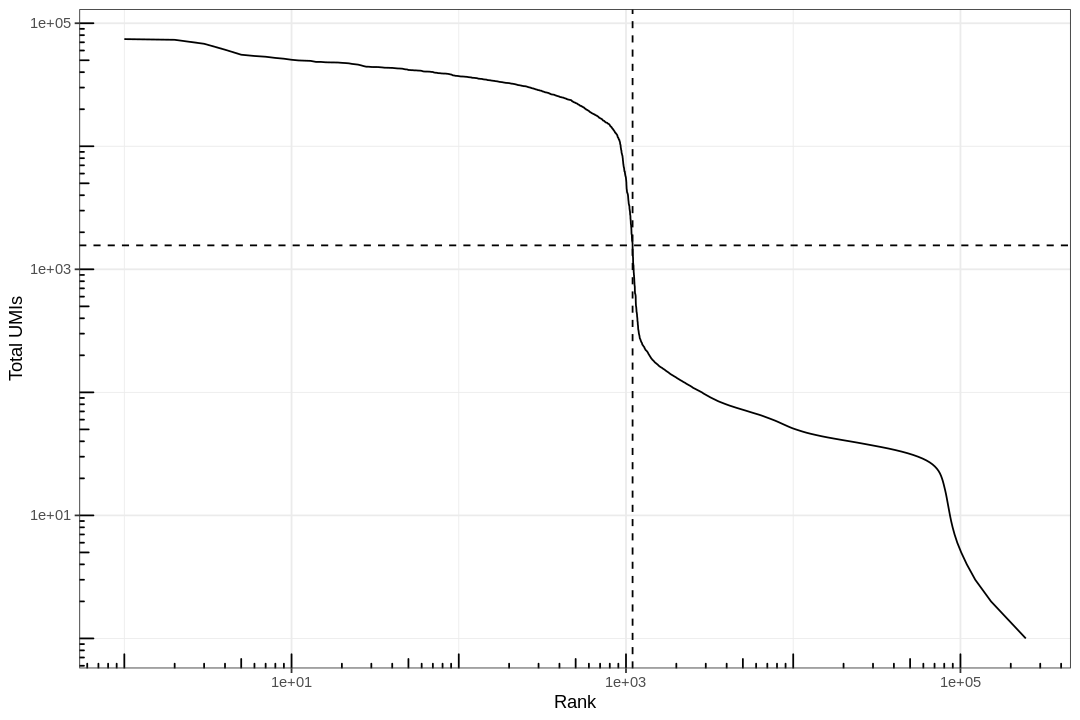

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

The inflection point looks like a reasonable number of cells.

In [0]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 37755  1095

## Cell species
How many cells are from humans and how many from mice? The number of cells with mixed species indicates doublet rate.

In [0]:
gene_species <- ifelse(str_detect(rownames(res_mat), "^ENSMUSG"), "mouse", "human")
mouse_inds <- gene_species == "mouse"
human_inds <- gene_species == "human"
# mark cells as mouse or human
cell_species <- tibble(n_mouse_umi = Matrix::colSums(res_mat[mouse_inds,]),
                       n_human_umi = Matrix::colSums(res_mat[human_inds,]),
                       tot_umi = Matrix::colSums(res_mat),
                       prop_mouse = n_mouse_umi / tot_umi,
                       prop_human = n_human_umi / tot_umi)

In [0]:
# Classify species based on proportion of UMI, with cutoff of 90%
cell_species <- cell_species %>% 
  mutate(species = case_when(
    prop_mouse > 0.9 ~ "mouse",
    prop_human > 0.9 ~ "human",
    TRUE ~ "mixed"
  ))

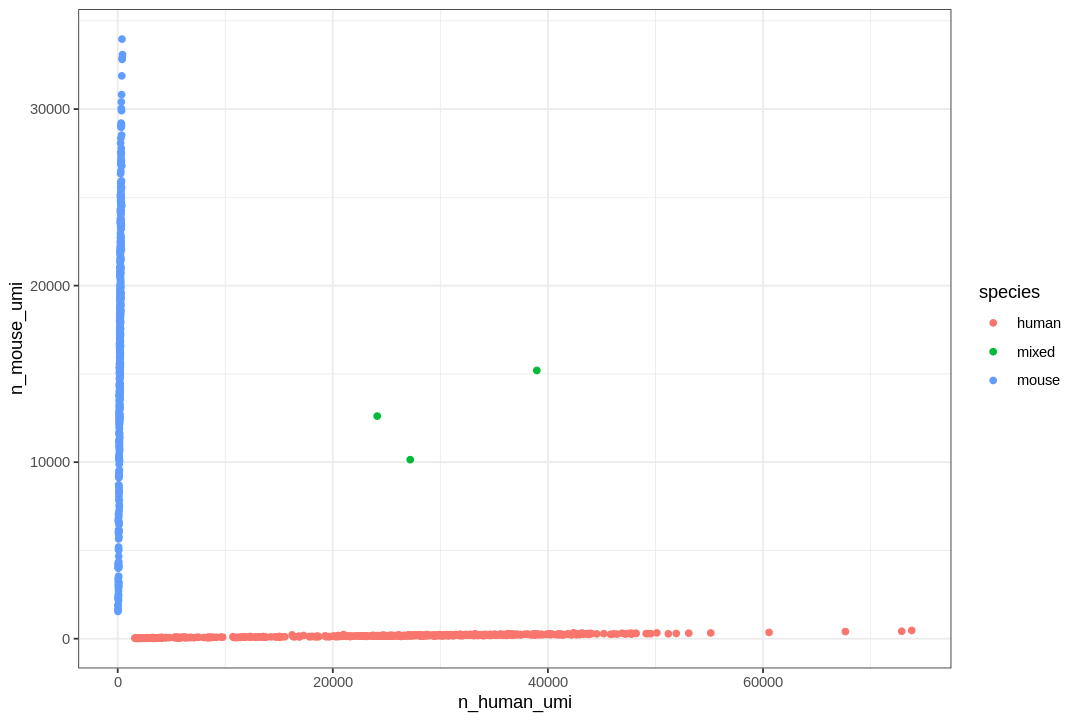

In [0]:
ggplot(cell_species, aes(n_human_umi, n_mouse_umi, color = species)) +
  geom_point()

Great, looks like the vast majority of cells are not mixed.

In [0]:
cell_species %>% 
  dplyr::count(species) %>% 
  mutate(proportion = n / ncol(res_mat))

species,n,proportion
<chr>,<int>,<dbl>
human,566,0.516894977
mixed,3,0.002739726
mouse,526,0.480365297


Great, only about 0.3% of cells here are doublets, which is lower than the ~1% 10x lists. Doublet rate tends to be lower when cell concentration is lower. However, doublets can still be formed with cells from the same species, so the number of mixed species "cells" is only a lower bound of doublet rate.

## Dimension reduction

In [0]:
seu <- CreateSeuratObject(res_mat, min.cells = 3) %>% 
  SCTransform(verbose = FALSE)

In [0]:
# Add species to meta data
seu <- AddMetaData(seu, metadata = cell_species$species, col.name = "species")

See how number of total counts and number of genes expressed are distributed.

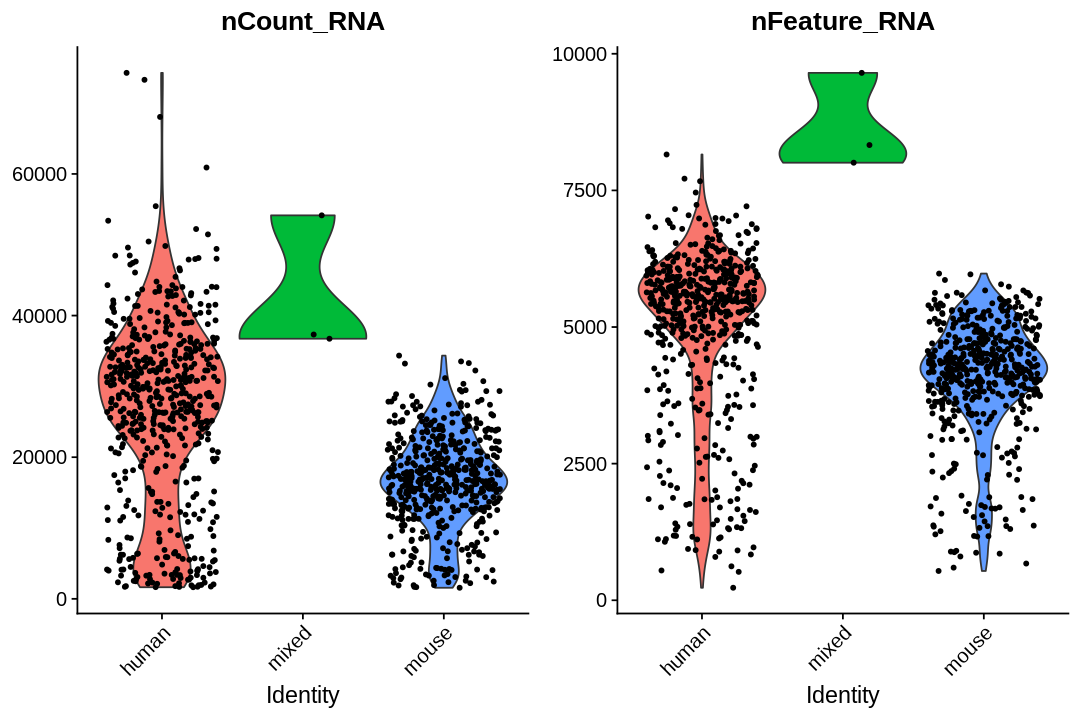

In [0]:
VlnPlot(seu, c("nCount_RNA", "nFeature_RNA"), group.by = "species")

Another QC plot

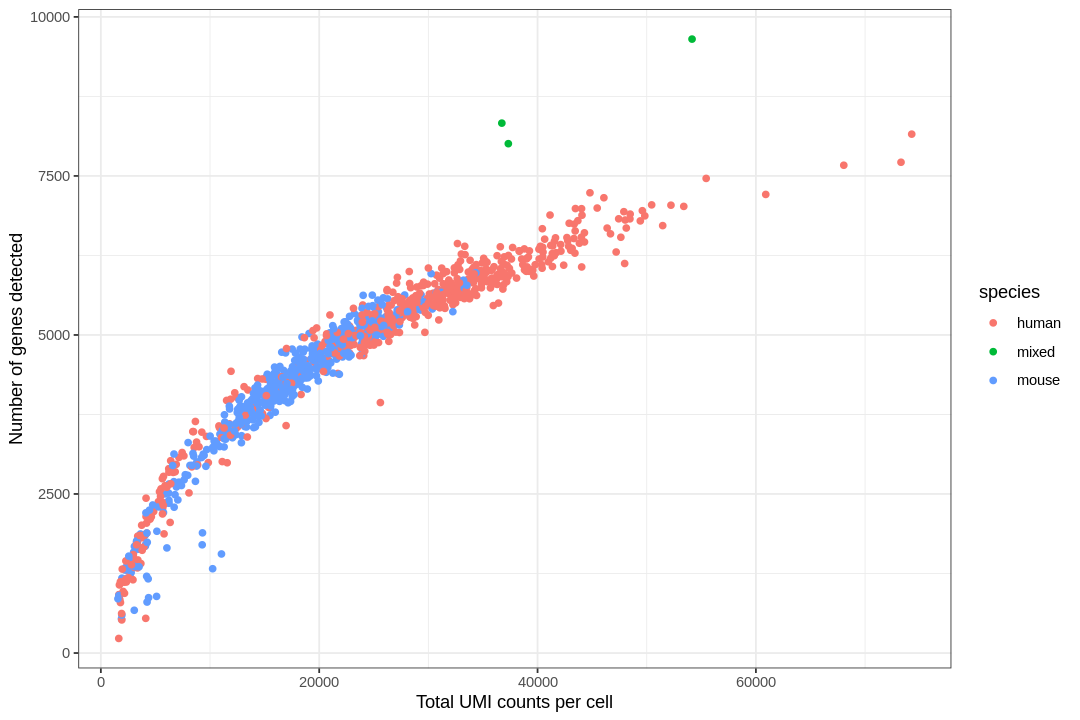

In [0]:
ggplot(seu@meta.data, aes(nCount_RNA, nFeature_RNA, color = species)) +
  geom_point() +
  labs(x = "Total UMI counts per cell", y = "Number of genes detected")

The mixed species doublets do look different from human and mouse cells.

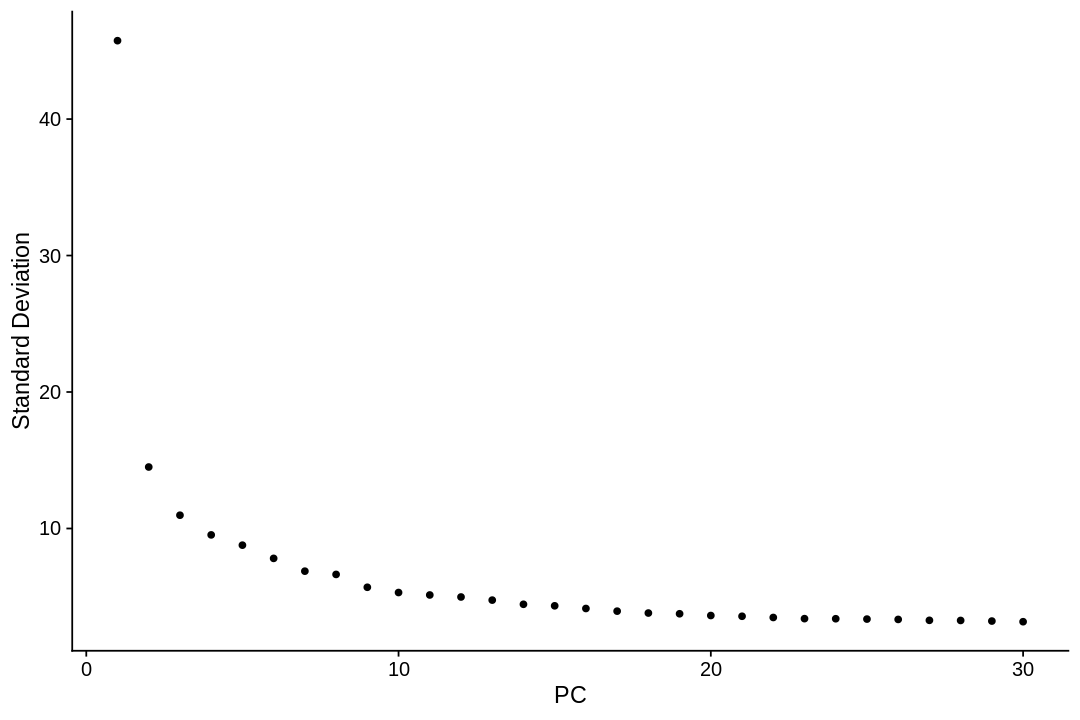

In [0]:
seu <- RunPCA(seu, verbose = FALSE, npcs = 30)
ElbowPlot(seu, ndims = 30)

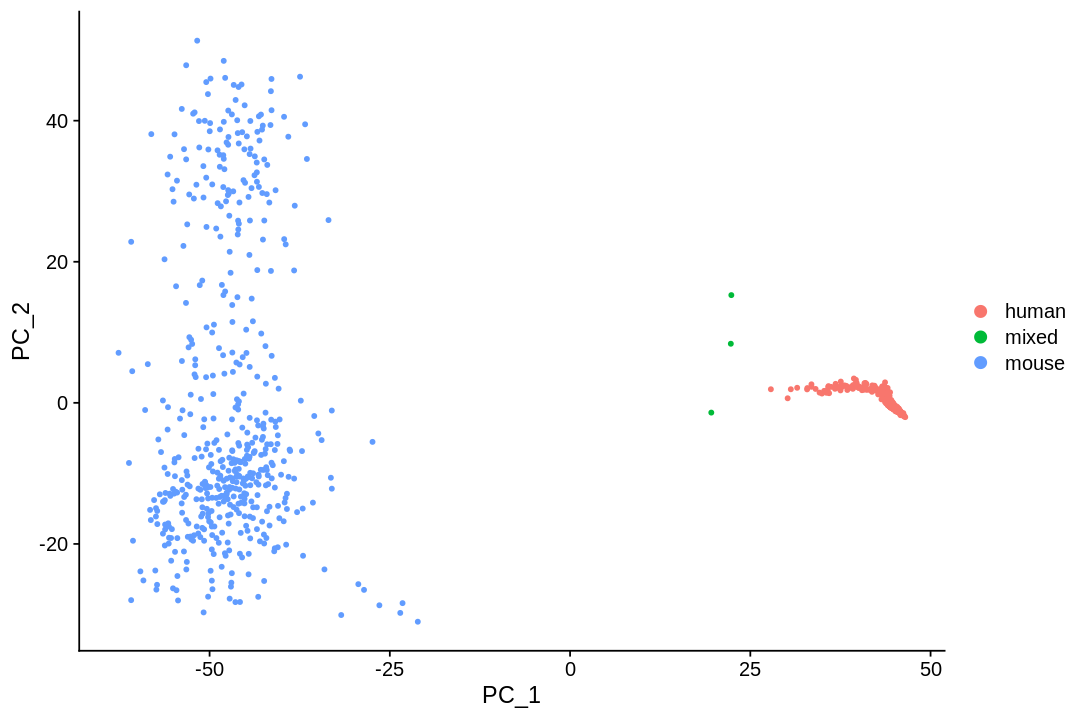

In [0]:
PCAPlot(seu, group.by = "species")

The first PC separates species, as expected. Also as expected, the doublets are in between human and mouse cells in this plot.

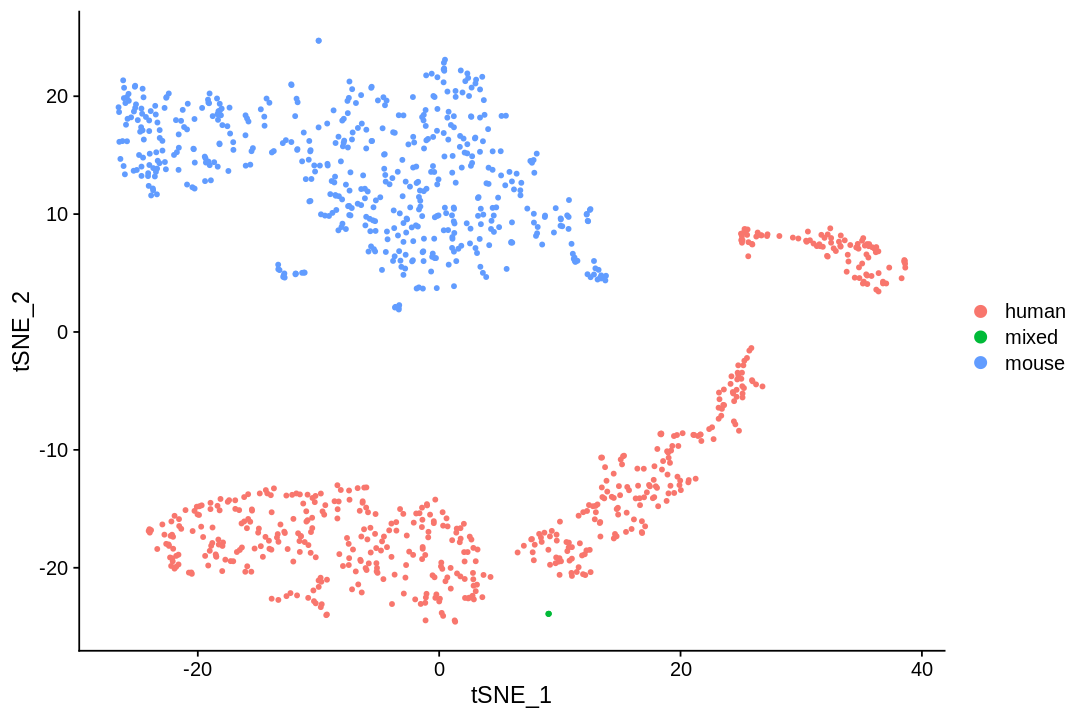

In [0]:
seu <- RunTSNE(seu, dims = 1:20, check_duplicates = FALSE)
TSNEPlot(seu, group.by = "species")

The species separate, and the few doublets form its own cluster, as expected.